In [ ]:
install.packages("parallelDist")
install.packages("dplyr")
install.packages("reshape")
install.packages("ggplot2")
install.packages("RcppArmadillo")
install.packages("RcppXPtrUtils")
install.packages("fastcluster")
install.packages("TSclust")
install.packages("forecast")

In [ ]:
library(fastcluster)
library(parallelDist) # https://www.rdocumentation.org/packages/parallelDist/versions/0.1.1/topics/parDist
library(dplyr)
library(forecast)
library(reshape)
library(ggplot2) # for vis
library(TSclust)
library(data.table)

In [23]:
library(RcppArmadillo)
library(RcppXPtrUtils)
corrdist <- cppXPtr("double customDist(const arma::mat &A, const arma::mat &B) {
                                 return sqrt( 2 * ( 1 - arma::accu(arma::cor(A , B)) )); }",
                      depends = c("RcppArmadillo"))

In [20]:
#time series data of 3816 groups
#Moving Average : q = 12(average cv result)
data = fread("usec_ns.csv")[, -1]
n = nrow(data)
m = ncol(data)
MA = 12
reduced = matrix(0, nrow = n, ncol = m - MA)
for (i in 1:n){
    reduced[i,] = forecast::ma(t(data[i,]), order = MA)[7:47]
}


In [22]:
dim(reduced)

[1] 3816   41

In [25]:
#ver1 : correlation-based measure
d1 <- parDist(reduced, method = "custom", func = corrdist)
d1[is.na(d1)] <- 0

In [26]:
#ver2 : Complexity-Invariant Distance measure
d2 <- diss(reduced, "CID")

In [27]:
hc1 <- fastcluster::hclust(d1, method = "ward.D")
hc2 <- fastcluster::hclust(d2, method = "ward.D")

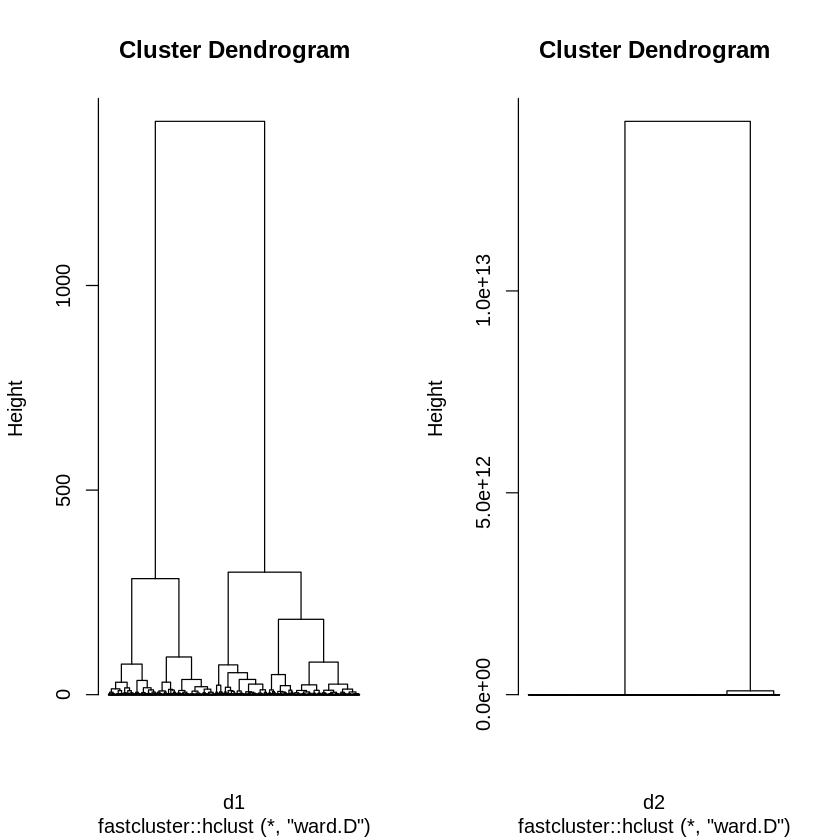

In [28]:
#hc1: Hierarchical Clustering for TS, dist = COR, method = "ward.D"
#hc2: Hierarchical Clustering for TS, dist = CID, method = "ward.D"
par(mfrow = c(1, 2))
plot(hc1, cex = 0.01, hang = -1, label = F)
plot(hc2, cex = 0.01, hang = -1, label = F)

In [29]:
#hc w COR distance matrix & ward.D
table(cutree(hc1, k = 3))
table(cutree(hc1, k = 4)) #***
table(cutree(hc1, k = 5)) #**
table(cutree(hc1, k = 6))
table(cutree(hc1, k = 7))
#hc w CID distance matrix & ward.D
table(cutree(hc2, k = 3))
table(cutree(hc2, k = 4))
table(cutree(hc2, k = 5)) #*
table(cutree(hc2, k = 6))
table(cutree(hc2, k = 7))


   1    2    3 
1624 1388  804 


   1    2    3    4 
 882 1388  804  742 


  1   2   3   4   5 
882 999 804 389 742 


  1   2   3   4   5   6 
583 999 804 389 742 299 


  1   2   3   4   5   6   7 
583 585 414 804 389 742 299 


   1    2    3 
 946 2729  141 


   1    2    3    4 
 946 2729  111   30 


   1    2    3    4    5 
 946 1066 1663  111   30 


   1    2    3    4    5    6 
 835 1066 1663  111  111   30 


   1    2    3    4    5    6    7 
 835 1066 1663   43   68  111   30 

In [30]:
write.csv(as.data.frame(cutree(hc1, k = 4)), "cor4.csv")
write.csv(as.data.frame(cutree(hc1, k = 5)), "cor5.csv")
write.csv(as.data.frame(cutree(hc2, k = 5)), "cid5.csv")